In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [8]:

graph = nx.read_graphml("graph/graph_file.graphml")


In [9]:
print(graph)

Graph with 4359 nodes and 6497 edges


### Calculating different centralities

In [25]:
degree_centralities = nx.degree_centrality(graph)
sorted_degree_centralities = sorted(degree_centralities.items(), key=lambda x: x[1], reverse=True)

betweenness_centralities = nx.betweenness_centrality(graph)
sorted_betweenness_centralities = sorted(betweenness_centralities.items(), key=lambda x: x[1], reverse=True)

closeness_centralities = nx.closeness_centrality(graph)
sorted_closeness_centralities = sorted(closeness_centralities.items(), key=lambda x: x[1], reverse=True)

pagerank_centralities = nx.pagerank(graph)
sorted_pagerank_centralities = sorted(pagerank_centralities.items(), key=lambda x: x[1], reverse=True)

eigenvector_centralities = nx.eigenvector_centrality(graph)
sorted_eigenvector_centralities = sorted(eigenvector_centralities.items(), key=lambda x: x[1], reverse=True)

In [28]:
topK = 50

In [29]:
topK_degree_centrality_list = sorted_degree_centralities[:topK]

topK_betweenness_centrality_list = sorted_betweenness_centralities[:topK]

topK_closeness_centrality_list = sorted_closeness_centralities[:topK]

topK_pagerank_centrality_list = sorted_pagerank_centralities[:topK]

topK_eigenvector_centrality_list = sorted_eigenvector_centralities[:topK]

In [30]:
import csv

In [35]:
def generate_protein_map(topK_degree_centrality_list, topK_betweenness_centrality_list, topK_closeness_centrality_list, topK_pagerank_centrality_list,topK_eigenvector_centrality_list):
    protein_map = {}
    for protein, _ in (topK_betweenness_centrality_list + topK_degree_centrality_list + topK_closeness_centrality_list + topK_pagerank_centrality_list+ topK_eigenvector_centrality_list):
        protein_map[protein] = {}
        protein_map[protein]['betweenness'] = 0
        protein_map[protein]['closeness'] = 0
        protein_map[protein]['degree'] = 0
        protein_map[protein]['pagerank'] = 0
        protein_map[protein]['eigen'] = 0
        
    for protein, score in topK_betweenness_centrality_list:
        protein_map[protein]['betweenness'] = score
    
    for protein, score in topK_closeness_centrality_list:
        protein_map[protein]['closeness'] = score
    
    for protein, score in topK_degree_centrality_list:
        protein_map[protein]['degree'] = score

    for protein, score in topK_pagerank_centrality_list:
        protein_map[protein]['pagerank'] = score
        
    for protein, score in topK_eigenvector_centrality_list:
        protein_map[protein]['eigen'] = score
        
    return protein_map

def generate_csv(protein_map, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        fieldnames = ['name', 'betweenness', 'closeness', 'pagerank', 'degree', 'eigen']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for protein, attributes in protein_map.items():
            writer.writerow({'name': protein, 'betweenness': attributes['betweenness'], 
                             'closeness': attributes['closeness'], 'pagerank': attributes['pagerank'], 
                             'degree': attributes['degree'], 'eigen': attributes['eigen']})
    

In [36]:
protein_map = generate_protein_map(topK_degree_centrality_list, topK_betweenness_centrality_list, topK_closeness_centrality_list, topK_pagerank_centrality_list, topK_eigenvector_centrality_list)

In [37]:
node_centralities_file_path = "graph_analysis/node_centralities.csv"

In [38]:
generate_csv(protein_map, file_path=node_centralities_file_path)

# Analysis

* BRCA1_HUMAN is top in all measures of centrality, need to cook some story on it. It is a crucial protein with a fking wikipedia page on it.
* In particular, proteins with a high betweenness and low degree value (HBLC, high betweenness low connectivity proteins) are prominent as they are supposed to support modularization of the network (See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2733090/)
* Below, our theory is supported since SOCS1_HUMAN is critical as a supressor of cytokine signalling.

In [24]:
degree_values = np.array(list(degree_centralities.values()))
betweenness_values = np.array(list(betweenness_centralities.values()))

degree_mean = np.mean(degree_values)
degree_sigma = np.std(degree_values)

betweenness_mean = np.mean(betweenness_values)
betweenness_sigma = np.std(betweenness_values)

low_degree_threshold = degree_mean - 0.25*degree_sigma
high_betweenness_threshold = betweenness_mean + 0.25*betweenness_sigma

proteins = []

for node in graph.nodes():
    if degree_centralities[node] < low_degree_threshold and betweenness_centralities[node] > high_betweenness_threshold:
        proteins.append(node)

print("Proteins with low degree centrality and high betweenness centrality:")
print(proteins)

Proteins with low degree centrality and high betweenness centrality:
['REPS2_HUMAN', 'NGAP_HUMAN', 'IQGA1_HUMAN', 'KLH38_HUMAN', 'KCNB2_HUMAN', 'COX5B_HUMAN', 'PAI2_HUMAN', 'SGTA_HUMAN', 'TRIO_HUMAN', 'DCAF7_HUMAN', 'PPM1F_HUMAN']


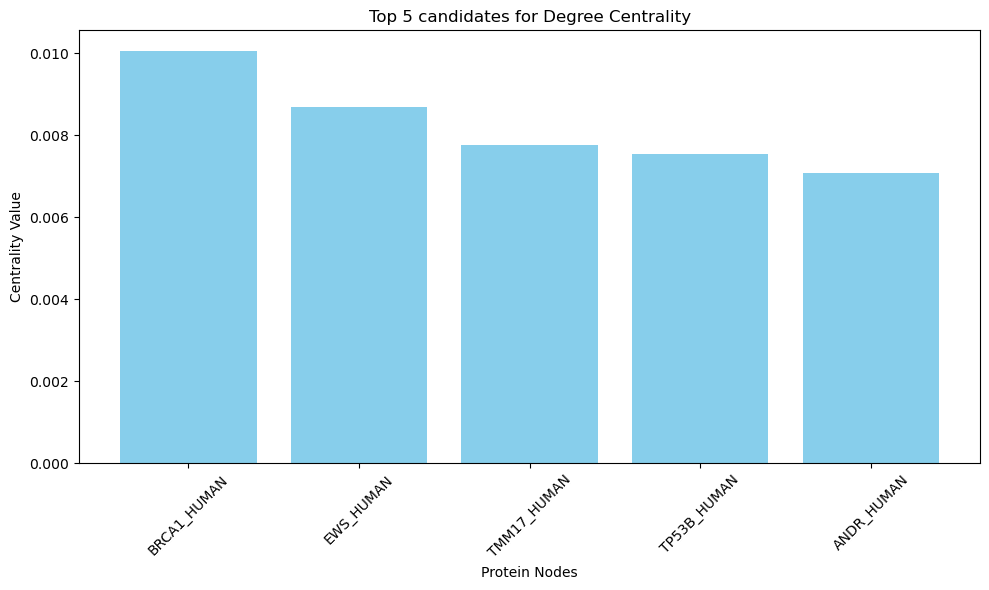

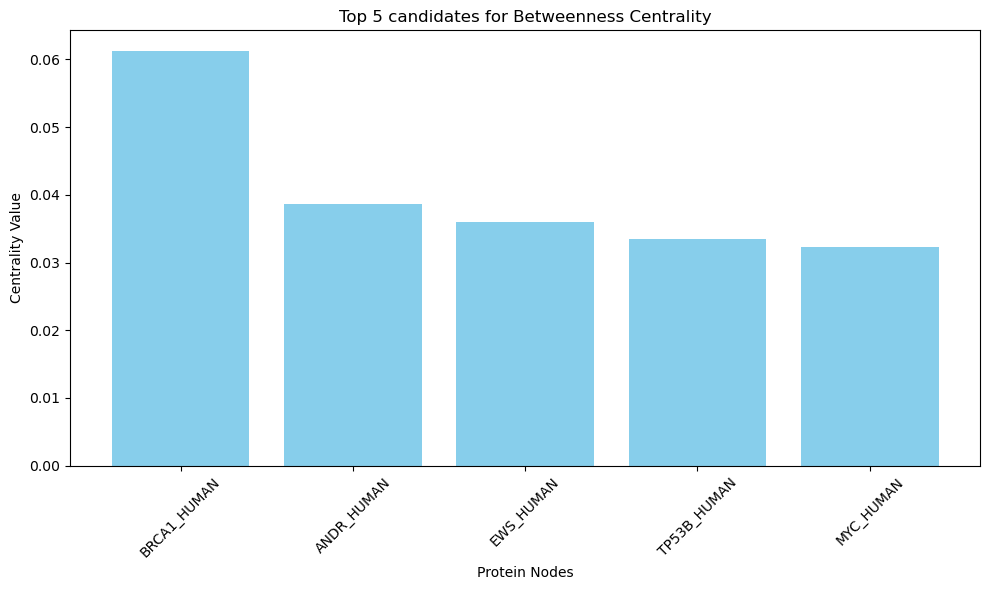

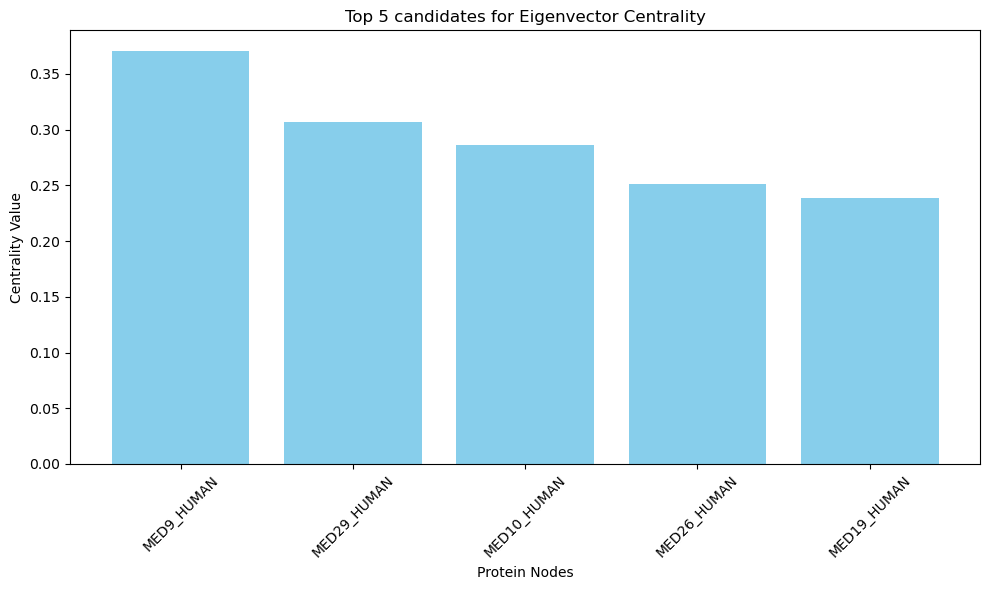

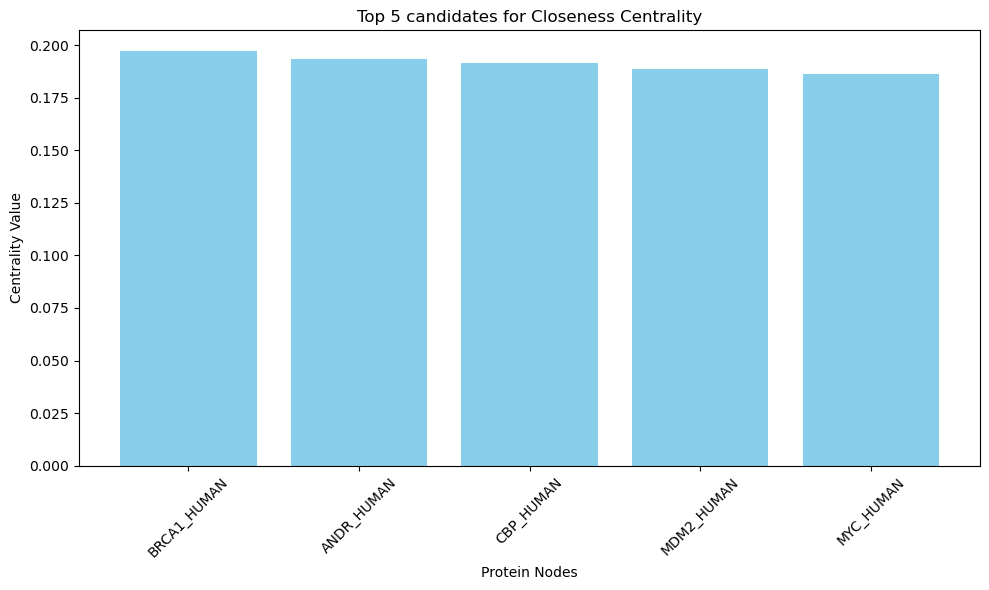

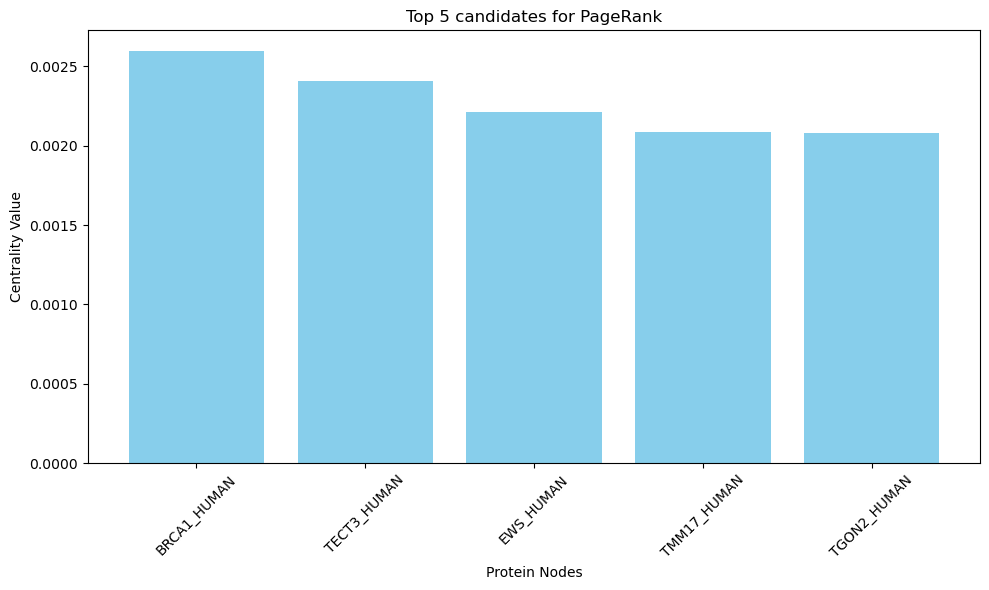

In [35]:
top_candidates = {
    "Degree Centrality": sorted_degree_centralities[:5],
    "Betweenness Centrality": sorted_betweenness_centralities[:5],
    "Eigenvector Centrality": sorted_eigenvector_centralities[:5],
    "Closeness Centrality": sorted_closeness_centralities[:5],
    "PageRank": sorted_pagerank_centralities[:5],
}

for centrality_measure, candidates in top_candidates.items():
    nodes = [candidate[0] for candidate in candidates]
    values = [candidate[1] for candidate in candidates]

    plt.figure(figsize=(10, 6))
    plt.bar(nodes, values, color='skyblue')
    plt.xlabel('Protein Nodes')
    plt.ylabel('Centrality Value')
    plt.title(f'Top 5 candidates for {centrality_measure}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# maximal cliques containing a highly central protein

In [53]:
central_protein = "ANDR_HUMAN"

brca1_cliques = nx.cliques_containing_node(graph, nodes=[central_protein])

for clique in brca1_cliques[central_protein]:
    if len(clique) > 2:  # Filter out cliques of size 2
        print("Nodes in maximal clique:", clique)

Nodes in maximal clique: ['UBC9_HUMAN', 'CBP_HUMAN', 'ANDR_HUMAN']
Nodes in maximal clique: ['NCOA3_HUMAN', 'CBP_HUMAN', 'ANDR_HUMAN']
Nodes in maximal clique: ['NCOA1_HUMAN', 'ANDR_HUMAN', 'CBP_HUMAN']
Nodes in maximal clique: ['BRCA1_HUMAN', 'CCND1_HUMAN', 'ANDR_HUMAN']
Nodes in maximal clique: ['BRCA1_HUMAN', 'CBP_HUMAN', 'ANDR_HUMAN']


/tmp/ipykernel_3331/335818776.py:3: DeprecationWarning: 

cliques_containing_node is deprecated and will be removed.
Use the result of find_cliques directly to compute maximal cliques
containing each node:

    {n: [c for c in nx.find_cliques(G) if n in c] for n in G}


  brca1_cliques = nx.cliques_containing_node(graph, nodes=[central_protein])


# all cliques of size K

In [49]:
clique_size = 5

all_cliques = list(nx.find_cliques(graph))
cliques_of_size = [clique for clique in all_cliques if len(clique) == clique_size]

print(f"All cliques of size {clique_size}:")
for clique in cliques_of_size:
    print(clique)

All cliques of size 5:
['DI3L1_HUMAN', 'EXOS9_HUMAN', 'EXOS5_HUMAN', 'EXOSX_HUMAN', 'EXOS8_HUMAN']
['MED10_HUMAN', 'MED9_HUMAN', 'MED29_HUMAN', 'MED6_HUMAN', 'MED1_HUMAN']
['MED10_HUMAN', 'MED28_HUMAN', 'MED6_HUMAN', 'MED1_HUMAN', 'MED29_HUMAN']


In [58]:
print(nx.number_connected_components(graph))
print(nx.has_bridges(graph))
print(nx.is_eulerian(graph))

308
True
False


In [59]:
core_vals = nx.core_number(graph)
print(core_vals)

NetworkXError: Input graph has self loops which is not permitted; Consider using G.remove_edges_from(nx.selfloop_edges(G)).